In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import spacy
import nltk
import os
import pickle

import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore')
pd.set_option('max_colwidth',1000)


%matplotlib inline

In [4]:
# Read in file.
dir_path = 'F:\\MOVIES\\us-consumer-finance-complaint-database'

df = pd.read_csv(os.path.join(dir_path, 'consumer_complaints.csv'))
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [5]:
# Get familiar with dataset.
df.shape

(66806, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 18 columns):
date_received                   66806 non-null object
product                         66806 non-null object
sub_product                     46351 non-null object
issue                           66806 non-null object
sub_issue                       32932 non-null object
consumer_complaint_narrative    66806 non-null object
company_public_response         32776 non-null object
company                         66806 non-null object
state                           66620 non-null object
zipcode                         66617 non-null object
tags                            11417 non-null object
consumer_consent_provided       66806 non-null object
submitted_via                   66806 non-null object
date_sent_to_company            66806 non-null object
company_response_to_consumer    66806 non-null object
timely_response                 66806 non-null object
consumer_disputed?   

In [7]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX X...",NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork b...",NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
190207,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,"I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments \n",NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,"

In [10]:
# Filter on text and label.
df = df[['product','consumer_complaint_narrative']]

In [11]:
# Experiment on smaller subset.
df = df[:25000]

In [12]:
# Distribution of target variable.
display(df['product'].value_counts())

# df[['product', 'sub_product']].apply(lambda x: str(x[0]) + '///' + str(x[1]),
#                                      axis=1).value_counts()

Debt collection            7093
Mortgage                   5703
Credit reporting           4584
Credit card                2750
Bank account or service    1923
Consumer Loan              1292
Student loan                917
Payday loan                 273
Money transfers             270
Prepaid card                154
Other financial service      41
Name: product, dtype: int64

Frequency(Top 30)...


,freq,count
Debt collection,0.28372,7093
Mortgage,0.22812,5703
Credit reporting,0.18336,4584
Credit card,0.11000,2750
Bank account or service,0.07692,1923
Consumer Loan,0.05168,1292
Student loan,0.03668,917
Payday loan,0.01092,273
Money transfers,0.01080,270
Prepaid card,0.00616,154


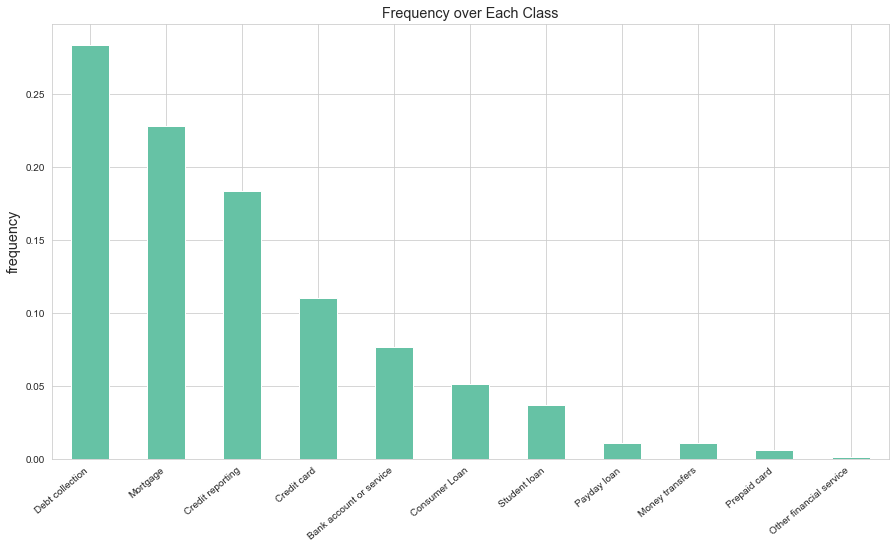

In [18]:
from UtilTextClassification import plot_freq

plot_freq(df, col=['product'], top_classes=30)

In [14]:
df.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n
190135,Consumer Loan,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX X..."
190155,Mortgage,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork b..."
190207,Mortgage,"I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments \n"
190208,Mortgage,"XXXX was submitted XX/XX/XXXX. At the time I submitted this complaint, I had dealt with Rushmore Mortgage directly endeavoring to get them to stop the continuous daily calls I was receiving trying to collect on a mortgage for which I was not responsible due to bankruptcy. They denied having knowledge of the bankruptcy, even though I had spoken with them about it repeatedly and had written them repeatedly referencing the bankruptcy requesting them to cease the pursuit, they continued to do so. When they were unable to trick me into paying, force me into paying in retaliation they placed reported to my credit bureaus a past due mortgage amount that had been discharged in Federal Court. On XX/XX/XXXX Rushmore responded the referenced complaint indicating that they would remove the reporting from my bureau, yet it is still there now in XX/XX/XXXX. I would like them to remove it immediately and send me a letter indicating that it should not have been there in the first place and they ar..."


In [15]:
import os

In [16]:
os.path

<module 'ntpath' from 'c:\\users\\rjra2611\\appdata\\local\\programs\\python\\python37\\lib\\ntpath.py'>

In [19]:
import spacy


nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
from UtilWordEmbedding import DocPreprocess



all_docs = DocPreprocess(nlp, stop_words, df['consumer_complaint_narrative'], df['product'])